# Анализ маркетинговых кампаний для игрового сервиса

### Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

### Загрузка данных

In [2]:
# Загружаем необходимые таблицы
df_payments = pd.read_csv("data/payments.csv")
df_persents = pd.read_csv("data/persents.csv", index_col=0)
df_registrations = pd.read_csv("data/registrations.csv", index_col=0)
df_budget = pd.read_excel("data/budget_01_21.xlsx")

In [3]:
# Проверяем загруженные данные
df_budget

,media_source,Campaign_type,Target,"Plan, USD",Installs,"Spend, USD","Deviation, USD"
0,Media_source_1,install,Brazil,100,10460,99.12,0.88
1,NaN,purchase,Brazil,400,1081,398.67,1.33
2,NaN,install,Russia,200,11894,246.30,-46.30
3,NaN,purchase,Russia,500,1441,616.77,-116.77
4,NaN,install,Ukrane,100,6424,99.43,0.57
5,NaN,purchase,Ukrane,500,242,348.13,151.87
6,Media_source_2,install,Brazil,100,152,81.15,18.85
7,NaN,install,English_speaking,100,371,99.95,0.05
8,Total,NaN,NaN,2000,32065,1989.52,10.48


In [4]:
df_payments

,payment_date,Payment_types,real_cost,account_id
0,2021-01-01 00:00:56,Payment_system_5,9.650000,2907221
1,2021-01-01 00:01:48,Payment_system_5,0.955872,3228373
2,2021-01-01 00:03:42,Payment_system_5,3.026930,318552
3,2021-01-01 00:04:27,Payment_system_2,99.990000,3832817
4,2021-01-01 00:06:41,Payment_system_5,1.432550,7229767
...,...,...,...,...
303609,2021-12-31 23:56:20,Payment_system_5,2.165630,4333575
303610,2021-12-31 23:57:05,Payment_system_5,47.111000,1129267
303611,2021-12-31 23:57:09,Payment_system_5,47.111000,583846
303612,2021-12-31 23:58:09,Payment_system_2,30.100000,4595502


In [5]:
df_registrations

,account_id,created_date,campaign
0,3842380.0,2021-01-01,BRA_MS1_install
1,3842381.0,2021-01-01,NaN
2,3842382.0,2021-01-01,NaN
3,3842383.0,2021-01-01,NaN
4,3842384.0,2021-01-01,BRA_MS1_install
...,...,...,...
89139,3931520.0,2021-01-31,NaN
89140,3931521.0,2021-01-31,NaN
89141,3931522.0,2021-01-31,NaN
89142,3931523.0,2021-01-31,NaN


In [6]:
df_persents

,Payment_types,"Share, %"
0,Payment_system_1,20.7
1,Payment_system_2,15.0
2,Payment_system_3,58.5
3,Payment_system_4,0.0
4,Payment_system_5,24.0


### Подготовка данных для анализа

In [7]:
# Проверяем типы данных и кол-во ненулевых значений в таблице df_registrations
df_registrations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89144 entries, 0 to 89143
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   account_id    89141 non-null  float64
 1   created_date  89144 non-null  object 
 2   campaign      36283 non-null  object 
dtypes: float64(1), object(2)
memory usage: 2.7+ MB


In [8]:
# Проверяем процент пропущенных значений в столбцах
((df_registrations.isna().sum() / len(df_registrations)) * 100).sort_values(ascending=False)

campaign        59.298438
account_id       0.003365
created_date     0.000000
dtype: float64

In [9]:
# Удалим строки в которых пропущен признак account_id
df_registrations.dropna(subset='account_id', inplace=True)

In [10]:
# Преобразуем признак account_id к целому числу
df_registrations['account_id'] = df_registrations['account_id'].astype('int')

In [11]:
# Преобразуем дату регистрации в необходимый тип
df_registrations['created_date'] = pd.to_datetime(df_registrations['created_date'])

In [12]:
# Проверим дубликаты
df_registrations.duplicated().sum()

0

In [13]:
# Проверим уникальный год и месяц регистрации, чтобы избежать искажения результатов анализа
df_registrations['created_date'].dt.month.value_counts()

created_date
1    89141
Name: count, dtype: int64

In [14]:
df_registrations['created_date'].dt.year.value_counts()

created_date
2021    89141
Name: count, dtype: int64

In [15]:
# Проверяем типы данных и кол-во ненулевых значений в таблице df_payments
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303614 entries, 0 to 303613
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   payment_date   303614 non-null  object 
 1   Payment_types  303614 non-null  object 
 2   real_cost      303614 non-null  float64
 3   account_id     303614 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 9.3+ MB


In [16]:
# Преобразуем дату оплаты в необходимый тип
df_payments['payment_date'] = pd.to_datetime(df_payments['payment_date'])

In [17]:
# Проверяем процент пропущенных значений в столбцах
((df_payments.isna().sum() / len(df_payments)) * 100).sort_values(ascending=False)

payment_date     0.0
Payment_types    0.0
real_cost        0.0
account_id       0.0
dtype: float64

In [18]:
# Проверим дубликаты
df_payments.duplicated().sum()

4

In [19]:
# Удалим дубликаты 
df_payments.drop_duplicates(inplace=True)

In [20]:
# Проверим уникальный год и месяц оплаты
df_payments['payment_date'].dt.month.value_counts()

payment_date
11    30857
10    29006
9     26761
12    26469
7     26007
1     25434
3     24766
8     24221
6     23756
4     23407
5     22124
2     20802
Name: count, dtype: int64

In [21]:
df_payments['payment_date'].dt.year.value_counts()

payment_date
2021    303610
Name: count, dtype: int64

In [22]:
# Объединим данные о платежах и коммисиях
merged_payments = df_payments.merge(df_persents, on='Payment_types', how='left')

# Добавляем колонку с чистым доходом
merged_payments['net_revenue'] = merged_payments['real_cost'] * (1 - merged_payments['Share, %']/100)

# Объединяем данные о регистрациях и платежах
full_data = df_registrations.merge(merged_payments, on='account_id', how='left')

# Создадим признак который показывает кол-во дней прошедших от момента регистрации до оплаты
full_data['days_since_registration'] = (full_data['payment_date'] - full_data['created_date']).dt.days
print('Кол-во строк до удаления отрицательных значений столбца: ',len(full_data))

# Так как у нас есть данные, где оплата произошла до регистрации, сделаем предположение, что клиент не может 
# произвести оплату до регистрации и удалим их, чтобы избежать искажения метрик
full_data = full_data.loc[(full_data['days_since_registration'] >= 0) | 
                            (pd.isna(full_data['days_since_registration']))]
print('Кол-во строк после удаления отрицательных значений столбца: ', len(full_data))

Кол-во строк до удаления отрицательных значений столбца:  94788
Кол-во строк после удаления отрицательных значений столбца:  94730


In [23]:
# Заполнение пропущенных значений в столбце media_source
df_budget['media_source'] = df_budget['media_source'].ffill()

# Удаление строки с 'Total'
index_names = df_budget[df_budget['media_source'] == 'Total'].index
df_budget.drop(index_names, inplace=True)

# Преобразование названий источников в числовые обозначения
df_budget['media_source'] = df_budget['media_source'].str.split('_').str[-1].astype(int)

# Преобразование названий стран в аббревиатуры
country_to_code = {'Brazil': 'BRA', 'Russia': 'RUS', 'Ukrane': 'UKR', 'English_speaking': 'ENG'}
df_budget['country_code'] = df_budget['Target'].map(country_to_code)

# Создание нового столбца campaign
def create_campaign(row):
    return f"{row['country_code']}_MS{row['media_source']}_{row['Campaign_type']}"

df_budget['campaign'] = df_budget.apply(create_campaign, axis=1)

### Анализ данных

#### Оптимальный срок оценки окупаемости рекламных кампаний

In [24]:
full_data

,account_id,created_date,campaign,payment_date,Payment_types,real_cost,"Share, %",net_revenue,days_since_registration
0,3842380,2021-01-01,BRA_MS1_install,NaT,NaN,NaN,NaN,NaN,NaN
1,3842381,2021-01-01,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,3842382,2021-01-01,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,3842383,2021-01-01,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,3842384,2021-01-01,BRA_MS1_install,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
94783,3931520,2021-01-31,NaN,NaT,NaN,NaN,NaN,NaN,NaN
94784,3931521,2021-01-31,NaN,NaT,NaN,NaN,NaN,NaN,NaN
94785,3931522,2021-01-31,NaN,NaT,NaN,NaN,NaN,NaN,NaN
94786,3931523,2021-01-31,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [25]:
full_data['payment_date_wo_time'] = full_data['payment_date'].dt.date

In [26]:
campaigns_date_net = full_data.groupby(['campaign', 'payment_date_wo_time'], 
                                      as_index=False).agg({'net_revenue': 'sum'})

In [27]:
campaigns_date_net['cumulative_net_revenue'] = campaigns_date_net.groupby('campaign')['net_revenue'].cumsum()

In [28]:
campaigns_budget = pd.merge(left=campaigns_date_net, right=df_budget[['campaign', 'Spend, USD']], how='inner', on='campaign')

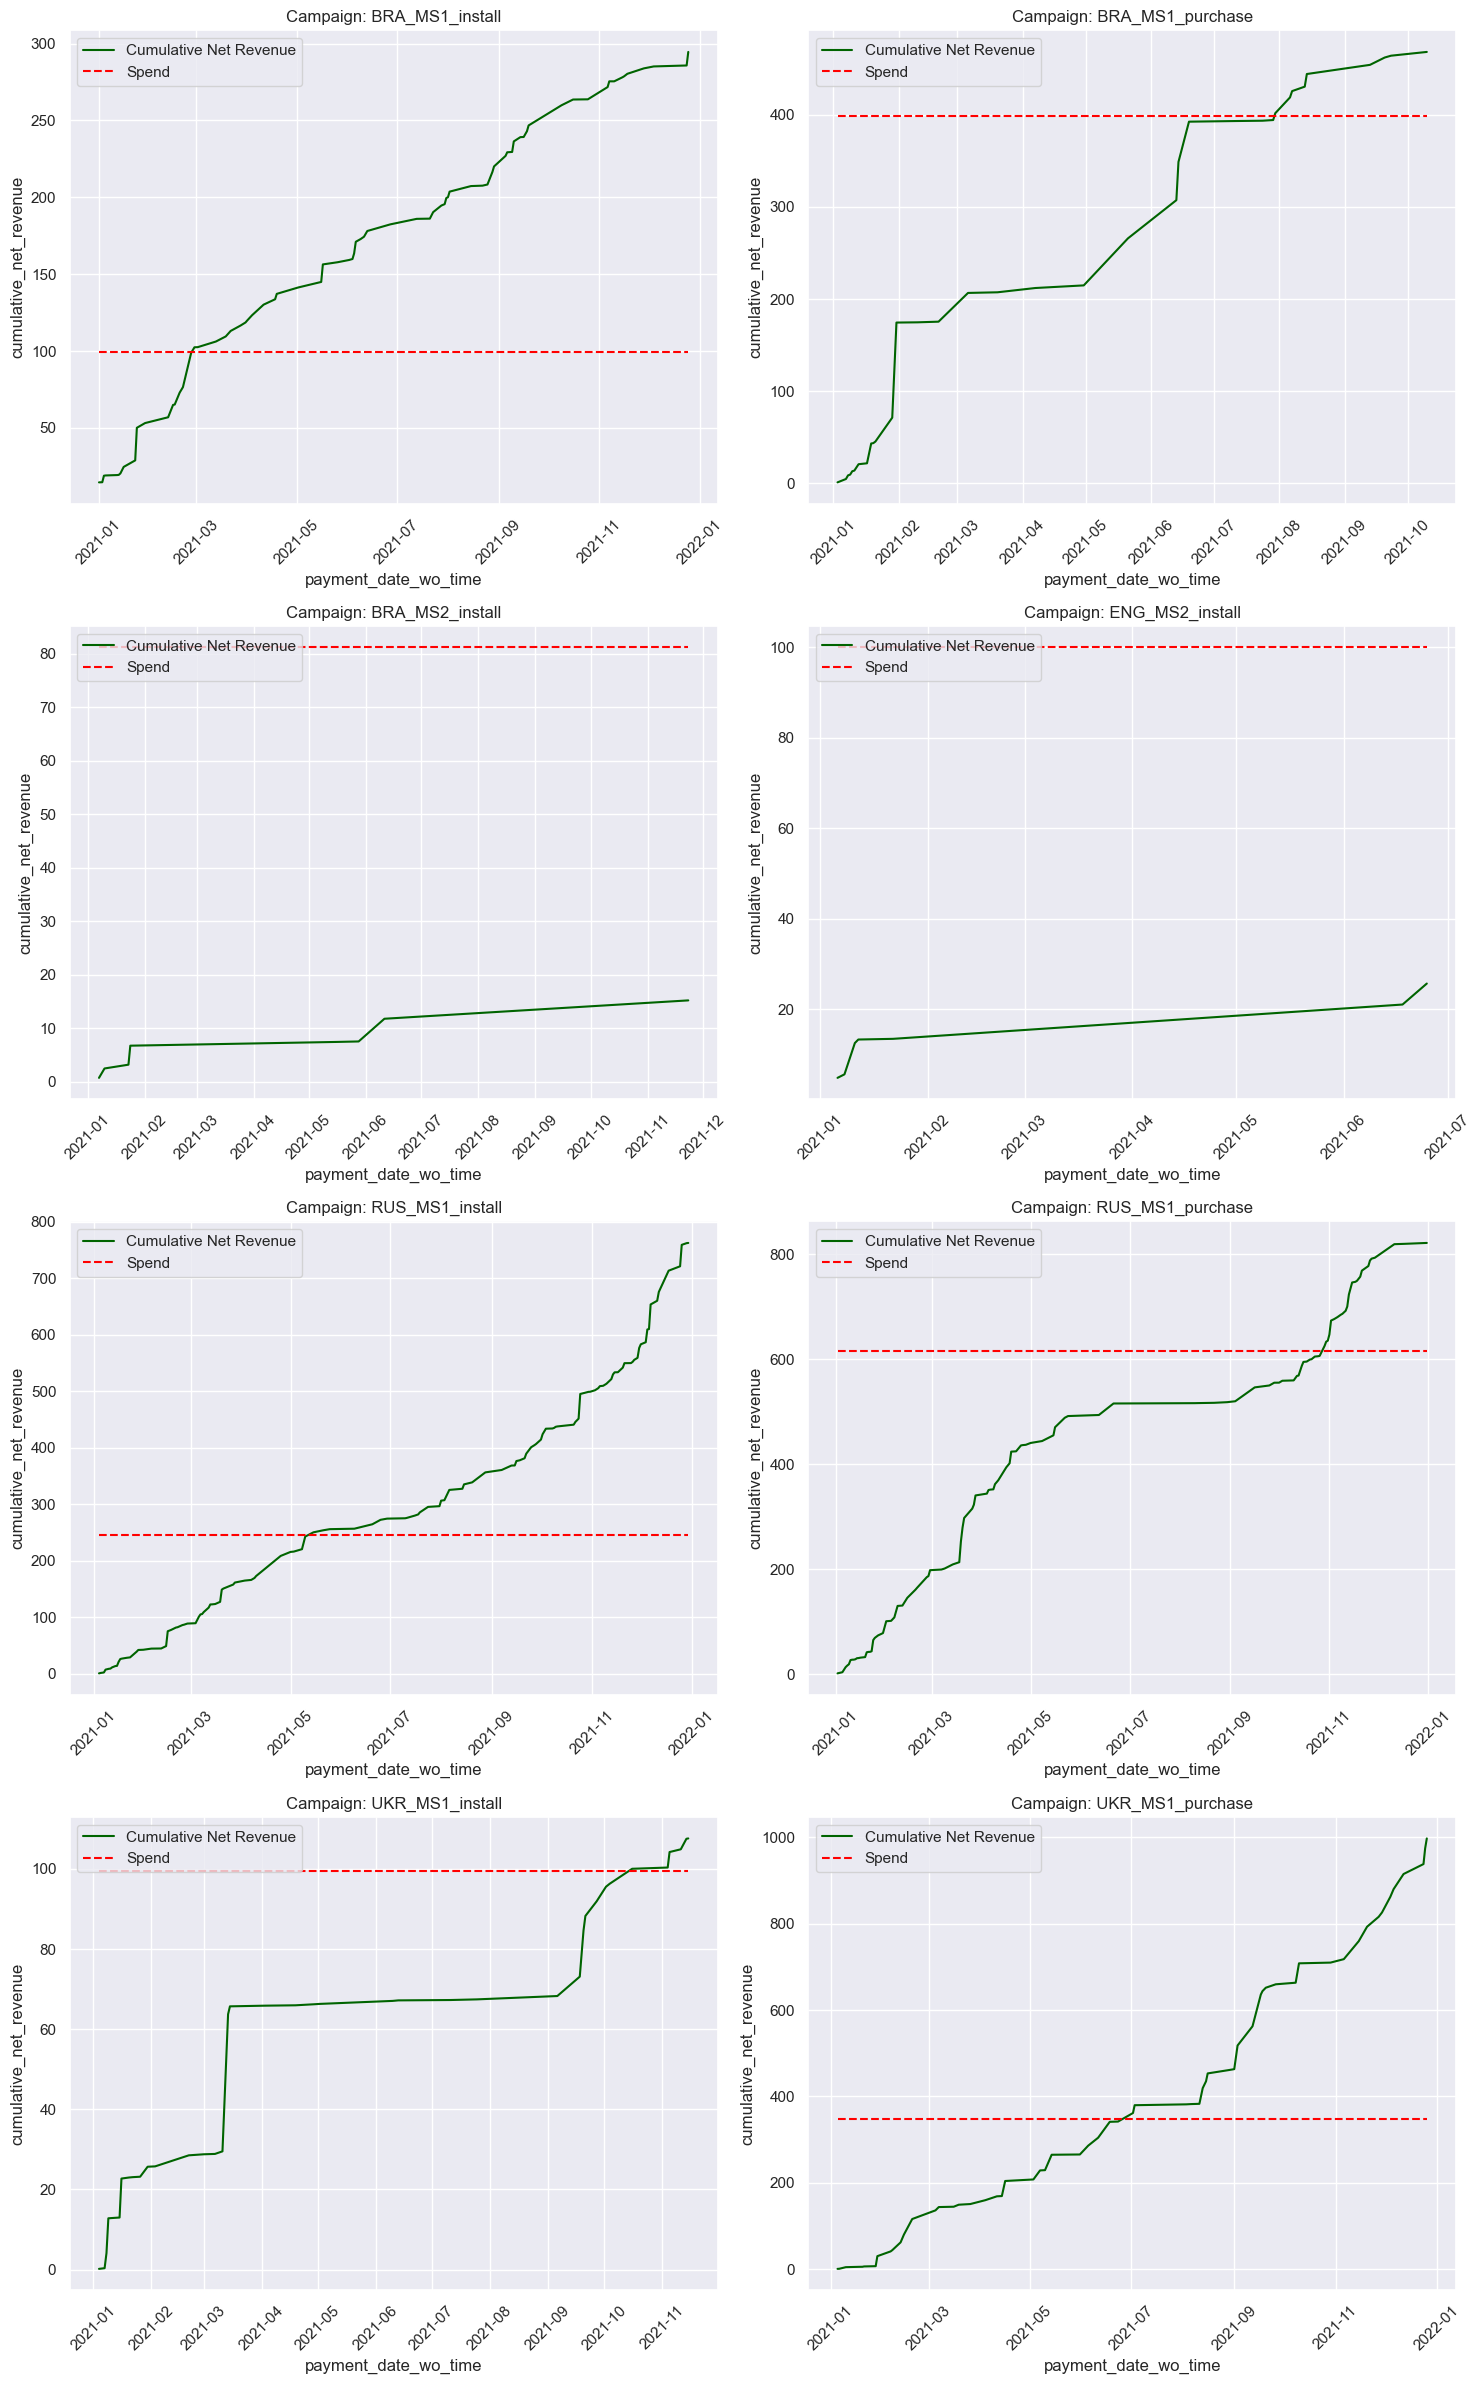

In [42]:
# Получим уникальные названия кампаний
unique_campaigns = campaigns_budget['campaign'].unique()

# Создадим фигуру с нужным количеством строк и столбцов
n_rows = len(unique_campaigns) // 2 + (len(unique_campaigns) % 2 > 0)
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 6 * n_rows))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i, campaign in enumerate(unique_campaigns):
    # Фильтруем данные по текущей кампании
    data = campaigns_budget.query("campaign == @campaign")
    
    # Строим график
    sns.set_theme()
    ax = axes[i]
    sns.lineplot(data=data, x='payment_date_wo_time', y='cumulative_net_revenue', 
                 label='Cumulative Net Revenue', color='darkgreen', ax=ax)
    sns.lineplot(data=data, x='payment_date_wo_time', y='Spend, USD', 
                 label='Spend', color='red', linestyle = '--', ax=ax)
    
    # Настраиваем заголовок и легенду
    ax.set_title(f'Campaign: {campaign}')
    ax.legend(loc='upper left')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

По построенным графикам видно, что кампании, запущенные во второй рекламной сети не окупились. Также срок который прошел с момента начала кампании до момента окупаемости различается от примерно 2-ух месяцев до 10 месяцев.

In [43]:
campaigns_budget['payback'] = np.where(campaigns_budget['cumulative_net_revenue'] >= campaigns_budget['Spend, USD'], 1, 0)
campaigns_budget['payment_date_wo_time'] = pd.to_datetime(campaigns_budget['payment_date_wo_time'])

In [44]:
campaigns_grouped = campaigns_budget.groupby('campaign', as_index=False).agg({'net_revenue': 'sum', 'Spend, USD': 'first'}) \
                                                    .merge(
campaigns_budget[campaigns_budget['payback']==1].groupby('campaign', as_index=False) \
                                                .agg({'payment_date_wo_time': 'min'}) \
                                                .rename(columns={'payment_date_wo_time': 'payback_date'}), 
                                                how='inner', on='campaign')

In [45]:
# Преобразование строки '2021-01-01' в объект datetime
start_date = datetime.strptime('2021-01-01', '%Y-%m-%d')

# Вычисление количества дней до payback_date относительно start_date
campaigns_grouped['days_to_payback'] = (campaigns_grouped['payback_date'] - start_date).dt.days

campaigns_grouped.rename(columns={'Spend, USD': 'spend'}, inplace=True)

In [46]:
campaigns_grouped['crr'] = round((campaigns_grouped['spend'] / campaigns_grouped['net_revenue']) * 100,2)

In [47]:
campaigns_grouped

,campaign,net_revenue,spend,payback_date,days_to_payback,crr
0,BRA_MS1_install,294.519408,99.12,2021-02-28,58,33.65
1,BRA_MS1_purchase,468.513559,398.67,2021-07-30,210,85.09
2,RUS_MS1_install,762.818000,246.30,2021-05-15,134,32.29
3,RUS_MS1_purchase,821.954812,616.77,2021-10-29,301,75.04
4,UKR_MS1_install,107.612396,99.43,2021-10-16,288,92.40
5,UKR_MS1_purchase,997.378637,348.13,2021-07-02,182,34.90


In [48]:
campaigns_grouped['days_to_payback'].mean()

195.5

In [49]:
campaigns_grouped.groupby(campaigns_grouped['campaign'].str.split('_').str[2])['days_to_payback'].mean()

campaign
install     160.0
purchase    231.0
Name: days_to_payback, dtype: float64

In [50]:
campaigns_grouped.groupby(campaigns_grouped['campaign'].str.split('_').str[0])['days_to_payback'].mean()

campaign
BRA    134.0
RUS    217.5
UKR    235.0
Name: days_to_payback, dtype: float64

Исходя из полученных расчетов, можно сказать что оптимальный срок оценки окупаемости рекламных кампаний составляет 196 дней. Если рассматривать оптимальный срок по типу кампании то это 160 дней для кампаний, которые оплачиваются за установку приложения и 231 дня для компаний, которые оплачиваются за совершенную покупку. Если смотреть на регионы то оптимальный срок оценки для Бразилии 134 дня, для России - 217 дней, для Украины - 235 дней.

#### Наиболее успешные рекламные кампании, типы рекламных кампаний, рекламные сети

In [51]:
# Рассчитаем возврат инвестиций для каждой кампании, которая окупилась.
campaigns_grouped['roi'] = 	(campaigns_grouped['net_revenue'] - 
                             campaigns_grouped['spend']) / campaigns_grouped['spend'] * 100


In [52]:
# Отсортируем кампании по roi
campaigns_grouped.sort_values('roi', ascending=False)

,campaign,net_revenue,spend,payback_date,days_to_payback,crr,roi
2,RUS_MS1_install,762.818000,246.30,2021-05-15,134,32.29,209.710921
0,BRA_MS1_install,294.519408,99.12,2021-02-28,58,33.65,197.134188
5,UKR_MS1_purchase,997.378637,348.13,2021-07-02,182,34.90,186.496032
3,RUS_MS1_purchase,821.954812,616.77,2021-10-29,301,75.04,33.267638
1,BRA_MS1_purchase,468.513559,398.67,2021-07-30,210,85.09,17.519141
4,UKR_MS1_install,107.612396,99.43,2021-10-16,288,92.40,8.229303


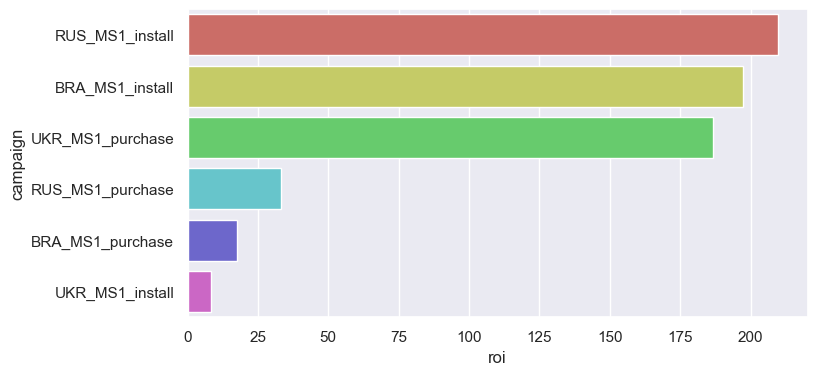

In [53]:
plt.rcParams['figure.figsize'] = [8, 4]

sns.barplot(x='roi', y='campaign', data=campaigns_grouped.sort_values('roi', ascending=False), 
            hue='campaign', palette='hls')

plt.show()

Лучшими рекламными кампаниями с близким уровнем roi в каждой стали кампании: RUS_MS1_install (210), BRA_MS1_install (197) и UKR_MS1_purchase (186)

In [55]:
# Сгруппируем данные по типу рекламных кампаний
type_grouped = campaigns_grouped.groupby(campaigns_grouped['campaign'].str.split('_').str[2]) \
                                .agg({'net_revenue': 'sum',
                                      'spend': 'sum'})

In [56]:
type_grouped['roi'] = (type_grouped['net_revenue'] - 
                        type_grouped['spend']) / type_grouped['spend'] * 100
type_grouped

,net_revenue,spend,roi
campaign,,,
install,1164.949803,444.85,161.874745
purchase,2287.847008,1363.57,67.783613


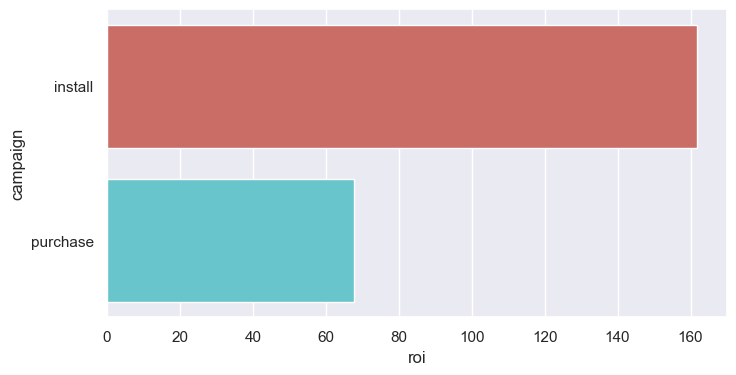

In [58]:
sns.barplot(x='roi', y='campaign', data=type_grouped.sort_values('roi', ascending=False), 
            hue='campaign', palette='hls')
plt.show()

Наиболее успешный тип рекламной кампании это рекламная кампания с оплатой за установку приложения (162 против 68)

Т.к ни одна из кампаний в рекламной сети 2 не окупилась, можно сделать вывод, что лучшей рекламной сетью является рекламная сеть номер один.

#### Расчет накопительного ARPU

In [62]:
# Находим пользователей которые участвовали в успешных рекламных кампаниях
successful_campaigns = full_data[full_data['campaign'].isin(campaigns_grouped['campaign'])]

In [63]:
# Группируем данные по дням и суммируем доходы
grouped_by_days = successful_campaigns.groupby(['days_since_registration'])['real_cost'].sum().reset_index()

# Создаем вспомогательную функцию для расчета накопительных значений
def cumulative_sum(df, column):
    return df[column].cumsum()

# Применяем функцию для получения кумулятивных сумм доходов
grouped_by_days['cumulative_revenue'] = cumulative_sum(grouped_by_days, 'real_cost')

# Считаем общее количество уникальных пользователей
total_users = len(successful_campaigns['account_id'].unique())

# Выбираем строки с нужными днями и вычисляем ARPU
arpu_7_day = grouped_by_days.query("days_since_registration == 6")['cumulative_revenue'].values[0] / total_users
arpu_14_day = grouped_by_days.query("days_since_registration == 13")['cumulative_revenue'].values[0] / total_users
arpu_30_day = grouped_by_days.query("days_since_registration == 29")['cumulative_revenue'].values[0] / total_users

print(f'Накопительный ARPU на 7-й день: {arpu_7_day:.4f}')
print(f'Накопительный ARPU на 14-й день: {arpu_14_day:.4f}')
print(f'Накопительный ARPU на 30-й день: {arpu_30_day:.4f}')

Накопительный ARPU на 7-й день: 0.0120
Накопительный ARPU на 14-й день: 0.0148
Накопительный ARPU на 30-й день: 0.0235


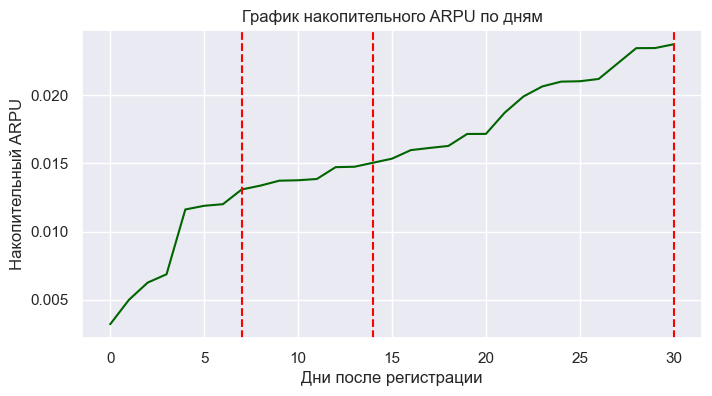

In [64]:
grouped_by_days['cumulative_arpu'] = grouped_by_days['cumulative_revenue'] / total_users

ax = sns.lineplot(x='days_since_registration', y='cumulative_arpu', data=grouped_by_days[grouped_by_days['days_since_registration'] <= 30], color='darkgreen')

# Добавление вертикальных линий
vertical_lines = [7, 14, 30]
for line in vertical_lines:
    ax.axvline(line, ls='--', c='red')

# Настройка осей и заголовка
ax.set_xlabel('Дни после регистрации')
ax.set_ylabel('Накопительный ARPU')
ax.set_title('График накопительного ARPU по дням')

plt.show()

Накопительная выручка на одного пользователя на 7-й день - 0.0120 центов, на 14-й день -  0.0148 центов и на 30-й день - 0.0235 цента.

#### Расчет фактического CPI

In [65]:
# Вычисление CPI для каждой рекламной кампании
cpi = df_budget['Spend, USD'] / df_budget['Installs']
df_budget['CPI'] = cpi

print(df_budget[['campaign', 'CPI']].sort_values(by='CPI'))

           campaign       CPI
0   BRA_MS1_install  0.009476
4   UKR_MS1_install  0.015478
2   RUS_MS1_install  0.020708
7   ENG_MS2_install  0.269407
1  BRA_MS1_purchase  0.368797
3  RUS_MS1_purchase  0.428015
6   BRA_MS2_install  0.533882
5  UKR_MS1_purchase  1.438554


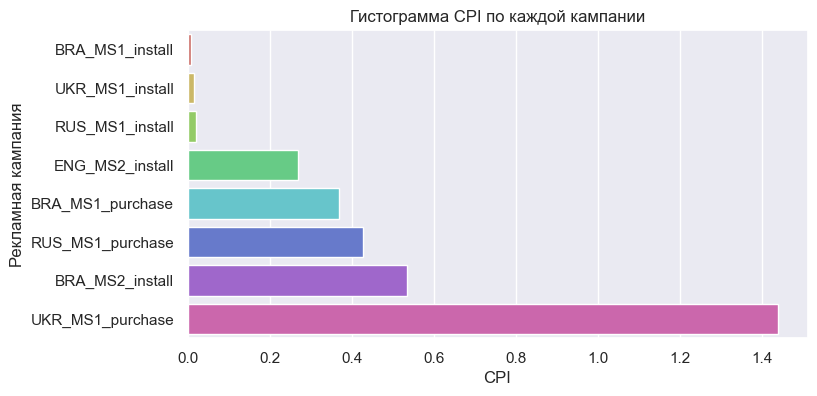

In [66]:
ax = sns.barplot(y="campaign", x="CPI", data=df_budget.sort_values(by='CPI'), hue='campaign', palette='hls')

# Настраиваем оси и заголовок
plt.xlabel('CPI')
plt.ylabel('Рекламная кампания')
plt.title('Гистограмма CPI по каждой кампании')

# Отображаем график
plt.show()